In [1]:
# CELL to import and set up matplotlib for the entire notebook
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["savefig.dpi"] = 96
plt.rcParams["savefig.format"] = 'pdf'
plt.rcParams["figure.figsize"] = (6,6)
%matplotlib widget
%matplotlib notebook

# Tension spring stiffness single parameter

In [4]:
from symulathon import Simulation
import numpy as np
from tqdm import tqdm
from simulation_functions import simulate

In [5]:
sim = Simulation(1, 1)
nDoF = sim.getDoF()
mass = sim.getMassMatrix()
h = sim.getTimeStep()
DIFF_FRAMES = 100

k_values = np.linspace(0.01, 40, 200)
g_values = []
dgdp_values = []
for k in tqdm(k_values):
    bp = simulate(k, 0.1, DIFF_FRAMES)
    g_values.append(bp.get_g())
    dgdp_values.append(bp.get_dgdp()[0])

# Calculate finite differences
dgdp_finite = []
for i in range(len(g_values)-1):
    value = (g_values[i+1]-g_values[i]) / (k_values[i+1] - k_values[i])
    dgdp_finite.append(value)
dgdp_finite.append(dgdp_finite[-1])

  4%|██████                                                                                                                                  | 9/200 [00:05<01:58,  1.61it/s]


KeyboardInterrupt: 

In [ ]:
plt.close()
plt.plot(k_values, g_values, "-", label="Loss Function")
plt.plot(k_values, dgdp_finite, ".", label="Finite $\\frac{\mathrm{d}g}{\mathrm{d}p}$")
plt.plot(k_values, dgdp_values, "x", label="Back propagation $\\frac{\mathrm{d}g}{\mathrm{d}p}$")
error = abs(np.array(dgdp_finite) - np.array(dgdp_values))
# plt.errorbar(k_values, dgdp_values, yerr = error)
plt.legend()
plt.xlabel("$k_s$")
#plt.ylim(-70,30)
plt.grid()
plt.show()
plt.savefig('figures/test.pdf')
print("Finished succesfully")

# Tilt angle single parameter

In [3]:
from symulathon import Simulation
from simulation_functions import newton_iteration
from recorder import SimulationReader
from backpropagation import Backpropagation
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [4]:
k = 20
k_bend = 0.1
graphics=False
sim = Simulation(k, k_bend, 0, graphics)
DIFF_FRAMES = 100

def simulate(tilt_angle: float, diff_frames: int):
    nDoF = sim.getDoF()
    mass = sim.getMassMatrix()
    h = sim.getTimeStep()
    reader = SimulationReader(nDoF)
    sim.reset_simulation(k, k_bend, tilt_angle)
    dx0dp = sim.getInitialPositionJacobian()
    dv0dp = sim.getInitialVelocityJacobian()
    backpropagation = Backpropagation(mass, dx0dp, dv0dp, h)
    sim.fill_containers()
    for i in range(DIFF_FRAMES+1):
        ##################################
        # Record step for backpropagation
        ##################################
        x = sim.getPosition()
        v = sim.getVelocity()
        x_t, v_t = reader.get_next_state()
        A = sim.getEquationMatrix()
        dfdp = sim.getParameterJacobian()
        dfdx = sim.getForcePositionJacobian()
        backpropagation.step(x, v, x_t, v_t, A, dfdp, dfdx)

        ##################################
        # Newton Iterations
        ##################################
        iterations = 3
        xi = x
        vi = v
        for it in range(iterations):
            xi, vi = newton_iteration(sim, x, v, xi, vi)
            sim.set_state(xi, vi)
            sim.fill_containers()

        sim.render_state()
    return backpropagation


In [21]:
nDoF = sim.getDoF()
mass = sim.getMassMatrix()
h = sim.getTimeStep()

angle_values = np.linspace(0, 360, 300)
g_values = []
dgdp_values = []
for angle in tqdm(angle_values):
    bp = simulate(np.radians(angle), DIFF_FRAMES)
    g_values.append(bp.get_g())
    dgdp_values.append(bp.get_dgdp()[3])

# Calculate finite differences
dgdp_finite = []
for i in range(len(g_values)-1):
    value = (g_values[i+1]-g_values[i]) / (angle_values[i+1] - angle_values[i])
    dgdp_finite.append(value)
dgdp_finite.append(dgdp_finite[-1])

  0%|          | 0/300 [00:00<?, ?it/s]

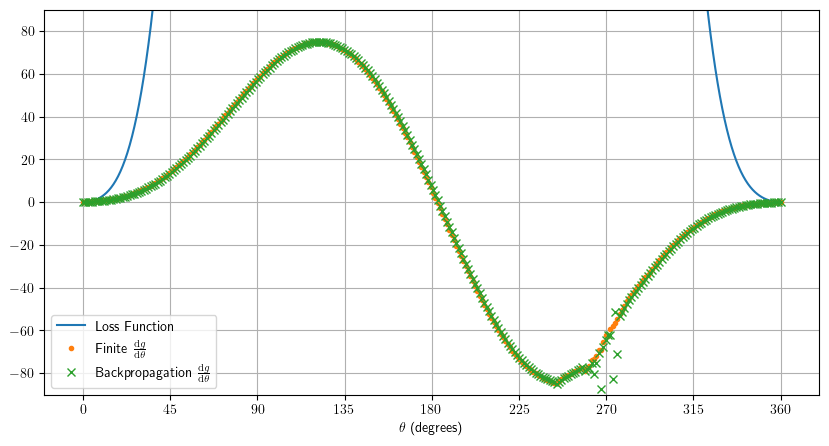

Finished succesfully


In [28]:
plt.rcParams["figure.figsize"] = (10,5)
plt.close()
plt.plot(angle_values, g_values, "-", label="Loss Function")
plt.plot(angle_values, dgdp_finite, ".", label="Finite $\\frac{\mathrm{d}g}{\mathrm{d}\\theta}$")
plt.plot(angle_values, dgdp_values, "x", label="Backpropagation $\\frac{\mathrm{d}g}{\mathrm{d}\\theta}$")

plt.legend()
plt.xlabel("$\\theta$ (degrees)")
plt.ylim(-90,90)
plt.xlim(-20,380)
plt.grid()
plt.xticks(np.linspace(0,360,9))
plt.show()
plt.savefig("figures/test.pdf")
print("Finished succesfully")

# Two diferential parameters: tension and bending spring stiffness

In [2]:
from symulathon import Simulation
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm
from simulation_functions import simulate
from concurrent import futures

In [3]:
# Initialize important constant variables
sim = Simulation(1, 1)
nDoF = sim.getDoF()
mass = sim.getMassMatrix()
h = sim.getTimeStep()
DIFF_FRAMES = 100

# Define the region studied
n_points = 20
k_values = np.linspace(19, 21, n_points)
k_bend_values = np.linspace(0, 0.3, n_points)
X, Y = np.meshgrid(k_values, k_bend_values, indexing='ij')
g_values = np.zeros(X.shape)
dgdk_values = np.zeros(X.shape)
dgdk_bend_values = np.zeros(X.shape)

# Multi-core solution
pool = futures.ProcessPoolExecutor()
for i in tqdm(range(len(k_values))):
    k_values_i = [k_values[i]] * len(k_bend_values)
    DIFF_FRAMES_i = [DIFF_FRAMES] * len(k_bend_values)
    bps = pool.map(simulate, k_values_i, k_bend_values, DIFF_FRAMES_i)
    for j, bp in enumerate(bps):
        dgdp = bp.get_dgdp()
        dgdk_values[i][j] = dgdp[0]
        dgdk_bend_values[i][j] = dgdp[1]
        g_values[i][j] = bp.get_g()

  0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
# Finite differences
X, Y = np.meshgrid(k_values, k_bend_values, indexing='ij')
dk = k_values[1]-k_values[0]
dk_bend = k_bend_values[1]-k_bend_values[0]
g_values = np.array(g_values)
dgdk_values_finite, dgdk_bend_values_finite = np.gradient(g_values, dk, dk_bend)

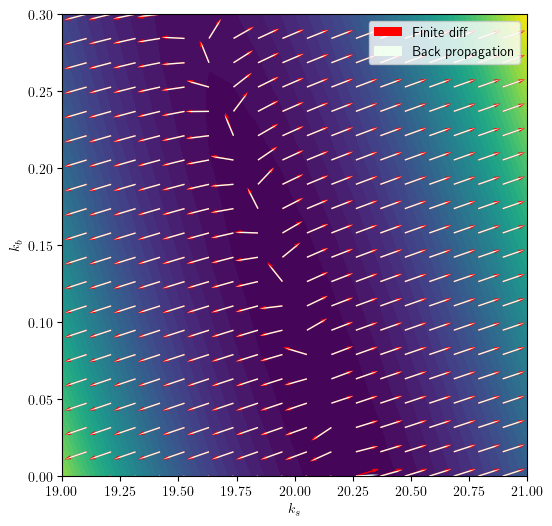

In [6]:
plt.close()

scale = (k_values[-1] - k_values[0]) / (k_bend_values[-1] - k_bend_values[0])

norm = np.sqrt((dgdk_values)**2 + (dgdk_bend_values)**2)
norm=1
scaled_norm = np.sqrt((dgdk_values*scale)**2 + (dgdk_bend_values)**2)
factor = norm / scaled_norm

dgdk_values_n = dgdk_values*scale*factor
dgdk_bend_values_n =dgdk_bend_values*factor
dgdk_values_finite_n = dgdk_values_finite*scale*factor
dgdk_bend_values_finite_n =dgdk_bend_values_finite*factor

arrow_len=10
plt.contourf(X, Y, g_values, levels=50)
plt.quiver(X, Y, dgdk_values_finite_n, dgdk_bend_values_finite_n/scale,
           label="Finite diff",
           angles='xy',
           scale_units="xy",
           color="red",
           scale=arrow_len)
plt.quiver(X, Y, dgdk_values_n, dgdk_bend_values_n/scale,
           label="Back propagation",
           angles='xy',
           scale_units="xy",
           color="honeydew",
           headwidth=1,
           scale=arrow_len)

plt.legend()
plt.xlabel("$k_s$")
plt.ylabel("$k_b$")
plt.show()
plt.savefig("figures/test.pdf")

In [25]:
print(np.mean(dgdk_values - dgdk_values_finite), np.var(dgdk_values - dgdk_values_finite))
print(np.mean(dgdk_bend_values - dgdk_bend_values_finite), np.var(dgdk_bend_values - dgdk_bend_values_finite))

-0.009357378721208214 0.00238379378646245
-0.0279927045080029 0.0041776147823540475


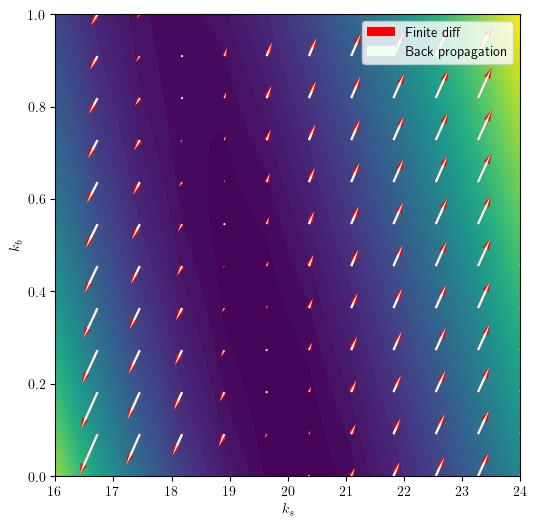

In [5]:
# Plotting
plt.close()

scale = (k_values[-1] - k_values[0]) / (k_bend_values[-1] - k_bend_values[0])
arrow_len=None
plt.contourf(X, Y, g_values, levels=60)
plt.quiver(X, Y, dgdk_values_finite*scale, dgdk_bend_values_finite,
           label="Finite diff",
           angles='xy',
           scale_units="xy",
           color="red",
           scale=arrow_len)
plt.quiver(X, Y, dgdk_values*scale, dgdk_bend_values,
           label="Back propagation",
           angles='xy',
           scale_units="xy",
           color="honeydew",
           # alpha=0.7,
           headwidth=1,
           scale=arrow_len)

plt.legend()
plt.xlabel("$k_s$")
plt.ylabel("$k_b$")
plt.show()
plt.savefig("figures/test.pdf")

In [ ]:
# save the data to disk
np.save("data/x_data.npy", X)
np.save("data/y_data.npy", Y)
np.save("data/g_data.npy", g_values)
np.savez("data/dgdk_data.npy",
         dgdk_values,
         dgdk_bend_values,
         dgdk_values_finite,
         dgdk_bend_values_finite)

# Two different parameters: Angle and stiffness

In [3]:
from symulathon import Simulation
from simulation_functions import newton_iteration
from recorder import SimulationReader
from backpropagation import Backpropagation
import numpy as np
from tqdm.notebook import tqdm
from concurrent import futures

In [4]:
k_bend = 0.1
sim = Simulation(20, k_bend, 0, False)
DIFF_FRAMES = 100

def simulate(k: float, tilt_angle: float, diff_frames: int):
    nDoF = sim.getDoF()
    mass = sim.getMassMatrix()
    h = sim.getTimeStep()
    reader = SimulationReader(nDoF)
    sim.reset_simulation(k, k_bend, tilt_angle)
    dx0dp = sim.getInitialPositionJacobian()
    dv0dp = sim.getInitialVelocityJacobian()
    backpropagation = Backpropagation(mass, dx0dp, dv0dp, h)
    sim.fill_containers()
    # print(sim.getDiffParameters())
    for i in range(DIFF_FRAMES+1):
        ##################################
        # Record step for backpropagation
        ##################################
        x = sim.getPosition()
        v = sim.getVelocity()
        x_t, v_t = reader.get_next_state()
        A = sim.getEquationMatrix()
        dfdp = sim.getParameterJacobian()
        dfdx = sim.getForcePositionJacobian()
        backpropagation.step(x, v, x_t, v_t, A, dfdp, dfdx)

        ##################################
        # Newton Iterations
        ##################################
        iterations = 3
        xi = x
        vi = v
        for it in range(iterations):
            xi, vi = newton_iteration(sim, x, v, xi, vi)
            sim.set_state(xi, vi)
            sim.fill_containers()

        sim.render_state()
    return backpropagation

In [24]:
# Initialize important constant variables
nDoF = sim.getDoF()
mass = sim.getMassMatrix()
h = sim.getTimeStep()
DIFF_FRAMES = 100

# Define the region studied
n_points = 20
k_values = np.linspace(1, 40, n_points)
angle_values = np.linspace(-180, 180, n_points)
X, Y = np.meshgrid(k_values, angle_values, indexing='ij')
g_values = np.zeros(X.shape)
dgdk_values = np.zeros(X.shape)
dgdangle_values = np.zeros(X.shape)

#Multi-core solution
pool = futures.ProcessPoolExecutor()
for i in tqdm(range(len(k_values))):
    k_values_i = [k_values[i]] * len(angle_values)
    DIFF_FRAMES_i = [DIFF_FRAMES] * len(angle_values)
    bps = pool.map(simulate, k_values_i, np.radians(angle_values), DIFF_FRAMES_i)
    for j, bp in enumerate(bps):
        dgdp = bp.get_dgdp()
        dgdk_values[i][j] = dgdp[0]
        dgdangle_values[i][j] = dgdp[3]
        g_values[i][j] = bp.get_g()

  0%|          | 0/20 [00:00<?, ?it/s]

In [25]:
# Finite differences
X, Y = np.meshgrid(k_values, angle_values, indexing='ij')
dk = k_values[1]-k_values[0]
dangle = angle_values[1]-angle_values[0]
g_values = np.array(g_values)
dgdk_values_finite, dgdangle_values_finite = np.gradient(g_values, dk, dangle)

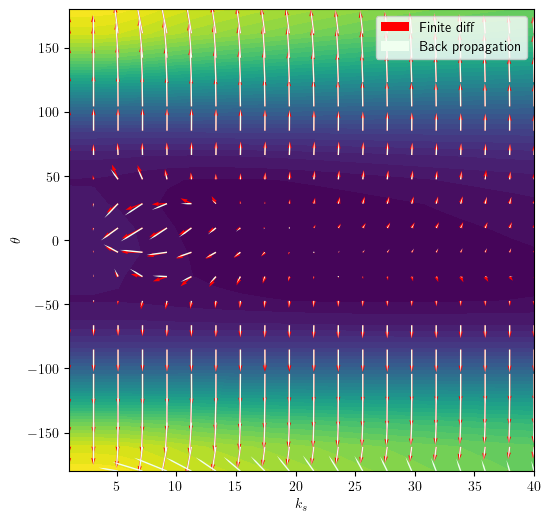

In [33]:
plt.close()

scale = (k_values[-1] - k_values[0]) / (angle_values[-1] - angle_values[0])

norm = np.sqrt((dgdk_values)**2 + (dgdangle_values)**2)
scaled_norm = np.sqrt((dgdk_values*scale)**2 + (dgdangle_values)**2)
factor = norm / scaled_norm

dgdk_values_n = dgdk_values*scale*factor
dgdangle_values_n =dgdangle_values*factor
dgdk_values_finite_n = dgdk_values_finite*scale*factor
dgdangle_values_finite_n =dgdangle_values_finite*factor

arrow_len=
plt.contourf(X, Y, g_values, levels=50)
plt.quiver(X, Y, dgdk_values_finite_n, dgdangle_values_finite_n/scale,
           label="Finite diff",
           angles='xy',
           scale_units="xy",
           color="red",
           scale=arrow_len)
plt.quiver(X, Y, dgdk_values_n, dgdangle_values_n/scale,
           label="Back propagation",
           angles='xy',
           scale_units="xy",
           color="honeydew",
           headwidth=1,
           scale=arrow_len)

plt.legend()
plt.xlabel("$k_s$")
plt.ylabel("$\\theta$")
plt.show()
plt.savefig("figures/test.pdf")

# Multiple stiffness parameters

In [2]:
from symulathon import Simulation
from simulation_functions import newton_iteration
from recorder import SimulationReader
from backpropagation import Backpropagation
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from concurrent import futures

In [3]:
# Compute the number of springs for a NxM grid
k = 20
k_bend = 0.1
graphics=False
sim = Simulation(k, k_bend, 0, graphics)
DIFF_FRAMES = 100

def compute_tension_springs(N, M):
    return (M-1)*(N-1) + N*(M-1) + M*(N-1)
def compute_bending_springs(N, M):
    return (M-1)*(N-1) + (N-2)*(M-1) + (M-2)*(N-1)

N, M = sim.getGridDimensions()
n_tension = compute_tension_springs(N,M)
n_bending = compute_bending_springs(N,M)
print(f"The grid is {N}x{M} meaning it has {n_tension} tension springs, {n_bending} bend springs which add up to a total of {n_bending + n_tension} springs.")

The grid is 20x20 meaning it has 1121 tension springs, 1045 bend springs which add up to a total of 2166 springs.


In [4]:
tension_stiffness = np.array([k]*n_tension)
bending_stiffness = np.array([k_bend]*n_bending)
graphics = False
sim = Simulation(tension_stiffness, bending_stiffness, graphics)

In [5]:
def simulate(stiffness_array: np.array, bend_stiffness_array: np.array, diff_frames: int):
    nDoF = sim.getDoF()
    mass = sim.getMassMatrix()
    h = sim.getTimeStep()
    reader = SimulationReader(nDoF)
    sim.reset_simulation(stiffness_array, bend_stiffness_array)
    dx0dp = sim.getInitialPositionJacobian()
    dv0dp = sim.getInitialVelocityJacobian()
    backpropagation = Backpropagation(mass, dx0dp, dv0dp, h)
    sim.fill_containers()
    for i in range(DIFF_FRAMES+1):
        ##################################
        # Record step for backpropagation
        ##################################
        x = sim.getPosition()
        v = sim.getVelocity()
        x_t, v_t = reader.get_next_state()
        A = sim.getEquationMatrix()
        dfdp = sim.getParameterJacobian()
        dfdx = sim.getForcePositionJacobian()
        backpropagation.step(x, v, x_t, v_t, A, dfdp, dfdx)

        ##################################
        # Newton Iterations
        ##################################
        iterations = 3
        xi = x
        vi = v
        for it in range(iterations):
            xi, vi = newton_iteration(sim, x, v, xi, vi)
            sim.set_state(xi, vi)
            sim.fill_containers()

        sim.render_state()
    return backpropagation

In [6]:
k = 40.0
k_bend = 1.0
DIFF_FRAMES = 100

tension_stiffness = np.array([k]*n_tension)
bending_stiffness = np.array([k_bend]*n_bending)
bp = simulate(tension_stiffness, bending_stiffness, DIFF_FRAMES)
dgdp = bp.get_dgdp()[:-1] # the last parameter is garbage
dgdp.shape

(2166,)

In [26]:
stiffness = np.concatenate((tension_stiffness, bending_stiffness))
n_stiffness = len(stiffness)
bp = simulate(tension_stiffness, bending_stiffness, DIFF_FRAMES)
g_base = bp.get_g()
dgdp = bp.get_dgdp()[:-1] # the last parameter is garbage
DK = 0.001

n_stiffness = 10
dg = np.array([0.]*n_stiffness)

DIFF_FRAMES_i = [DIFF_FRAMES]*n_stiffness
stiffness_i = [stiffness.copy() for i in range(n_stiffness)]
for i in range(n_stiffness):
    stiffness_i[i][i] += DK
    
def finite_simulate(stiffness: np.array):
    print("ola")
    bp = simulate(stiffness[:len(tension_stiffness)].copy(), stiffness[len(tension_stiffness):].copy(), DIFF_FRAMES)
    return bp.get_g()

g_base = finite_simulate(stiffness)
for i in range(n_stiffness):
    dg[i] = finite_simulate(stiffness_i[i])

ola
ola
ola
ola
ola
ola
ola
ola
ola
ola
ola


In [18]:
pool = futures.ProcessPoolExecutor(12)
bps = pool.map(finite_simulate, stiffness_i)
dg = np.array(list(bps))
dgdp_finite = (np.array([g_base]*n_stiffness) - dg) / DK

olaola
olaolaolaola
ola

olaola
ola






In [27]:
dgdp_finite = (np.array([g_base]*n_stiffness) - dg) / DK
print(g_base)
print(dg)

234.7664068407536
[234.60035503 234.73353074 234.78000093 234.65790732 234.15743796
 234.28653616 234.7394908  234.74422354 234.26309656 234.82435227]


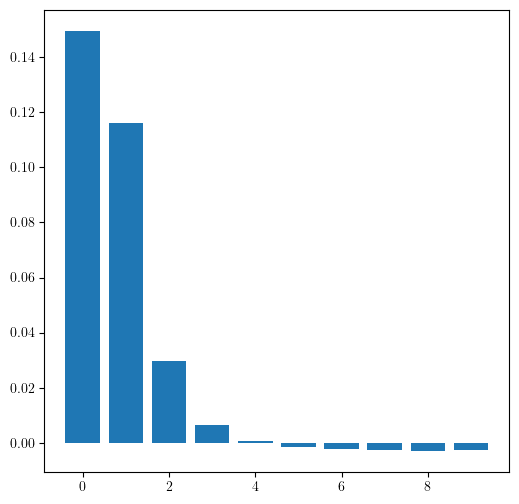

In [30]:
plt.close()
x = np.arange(0,len(dgdp), 1)
plt.bar(x[:n_stiffness], dgdp[:n_stiffness])
plt.show()

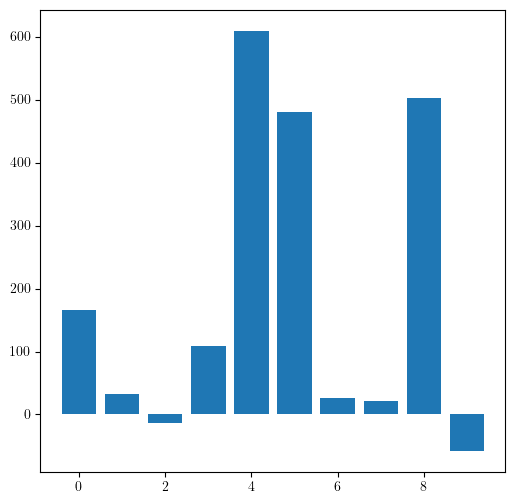

In [29]:
plt.close()
x = np.arange(0,len(dgdp), 1)
plt.bar(x[:n_stiffness], dgdp_finite)
plt.show()